In [1]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CONTEXT_LENGTH = 3
SPECIAL = '.'

## Class and functions definitions

In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, Y):
        super().__init__()
        assert(X.shape[0] == Y.shape[0])
        self.X, self.Y = X, Y

    def __getitem__(self, idx):
        return self.X[idx, ...], self.Y[idx, ...]

    def __len__(self):
        return self.X.shape[0]

In [4]:
def build_dataset_from_names(names: list, context_length: int, special_char: str):
    """
    Build dataset 
    """
    X = list()
    Y = list()
    prepend = "".join([special_char for i in range(context_length)])
    for n in names:
        n_ext = "".join([prepend, n, special_char])
        for i in range(len(n_ext) - context_length):
            x = n_ext[i:i + context_length]
            Y.append(chars_to_int[n_ext[i + context_length]])
            X.append([chars_to_int[c] for c in x])
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [62]:
class MLP(torch.nn.Module):

    def __init__(self, num_embeddings: int ,embedding_dim: int, hidden_dim: int, 
                 context_length: int, char_to_int: dict, original_architecture: bool = False):
        """
        Neural Probabilistic model as defined in the paper from Bengio. It is slightly different
        from what is described in the paper, since there are no skip connections between embedding
        and ouput layer.

        Parameters
        num_embeddings: number of embeddings
        embedding_dim: embedding dimension
        hidden_dim: dimension of the hidden layer
        context_length: number of characters to use for prediction
        char_to_int: mapping character -> int
        paper_architecture: if True add the skip connections as in the original paper
        """
        super().__init__()
        self.context_length = context_length
        self.embedding_dim = embedding_dim
        self.char_to_int = char_to_int
        self.int_to_char = {v: k for k, v in self.char_to_int.items()}
        self.original_architecture = original_architecture
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)
        self.hidden_layer = torch.nn.Linear(in_features=embedding_dim * context_length, 
                                            out_features=hidden_dim)

        self.hidden_activation = torch.nn.Tanh()
        if self.original_architecture:
            output_dim = hidden_dim + embedding_dim * context_length 
        else:
            output_dim = hidden_dim
            
        self.output_layer = torch.nn.Linear(in_features=output_dim, out_features=num_embeddings)
        self.output_activation = torch.nn.Softmax(dim=1)

    def initialize_kaiming(self, generator=None):
        self.hidden_layer.weight = torch.nn.init.kaiming_normal_(
            self.hidden_layer.weight, mode="fan_in", nonlinearity="tanh", generator=generator)
        self.output_layer.weight = torch.nn.init.kaiming_normal_(
            self.output_layer.weight, mode="fan_in", nonlinearity="linear", generator=generator)
        return self
    
    def forward(self, X):
        """
        Forward pass outputs unnormalized logits
        """
        C = self.embedding(X).view(-1, self.context_length * self.embedding_dim)
        out = self.hidden_layer(C)
        out = self.hidden_activation(out)
        if self.original_architecture:
            out = torch.cat([C, out], dim=1)
        out = self.output_layer(out)
        return out

    def predict_proba(self, X):
        """
        Predict next char proabilities
        """
        logits = self(X)
        return self.output_activation(logits)

    def generate_name(self, generator=None):
        with torch.no_grad():
            res = ""
            start = torch.tensor([[self.char_to_int[c] for c in SPECIAL * self.context_length]])
            next_char = ""
            while next_char != chars_to_int[SPECIAL]:
                probs = model.predict_proba(start)
                next_char = torch.multinomial(probs, num_samples=1, generator=generator)
                res += self.int_to_char[next_char.item()]
                new_start = torch.tensor([[c for c in start[0, 1:]] + [next_char]])
                start = new_start
        return res
        

In [6]:
def regularization(model):
    """
    Regularization loss as described in the paper
    """
    C = list(model.embedding.parameters())[0]
    W = list(model.hidden_layer.parameters())[0]
    O = list(model.hidden_layer.parameters())[0]
    return (C**2).sum() + (W**2).sum() + (O**2).sum()

## Create data

In [7]:
names = np.array(open("data/names_usa.txt").read().splitlines())

In [8]:
generator = torch.Generator().manual_seed(42)

In [9]:
chars = string.ascii_lowercase + SPECIAL
chars_to_int = {c: k for k,c in enumerate(chars)}
int_to_chars = {k: c for c, k in chars_to_int.items()}

In [10]:
n_names = len(names)
idx = torch.randperm(n_names, generator=generator)
tr_idx = idx[:int(n_names*0.8)]
dev_idx = idx[int(n_names*0.8):int(n_names*0.9)]
te_idx = idx[int(n_names*0.9):]

Xtr, Ytr = build_dataset_from_names(names[tr_idx], 
                               context_length=CONTEXT_LENGTH, 
                               special_char=SPECIAL)

Xdev, Ydev = build_dataset_from_names(names[dev_idx], 
                               context_length=CONTEXT_LENGTH, 
                               special_char=SPECIAL)

Xte, Yte = build_dataset_from_names(names[te_idx], 
                               context_length=CONTEXT_LENGTH, 
                               special_char=SPECIAL)

## Model

### Parameters

In [11]:
model_parameters = {
    "num_embeddings": len(chars),
    "embedding_dim": 15,
    "hidden_dim": 60,
    "context_length": CONTEXT_LENGTH,
    "char_to_int": chars_to_int,
    "original_architecture": False
}

epochs = 60
batch_size = 32
loss = torch.nn.CrossEntropyLoss()

## Initialization

Expected loss 3.295836866004329, initial loss 3.2718746662139893


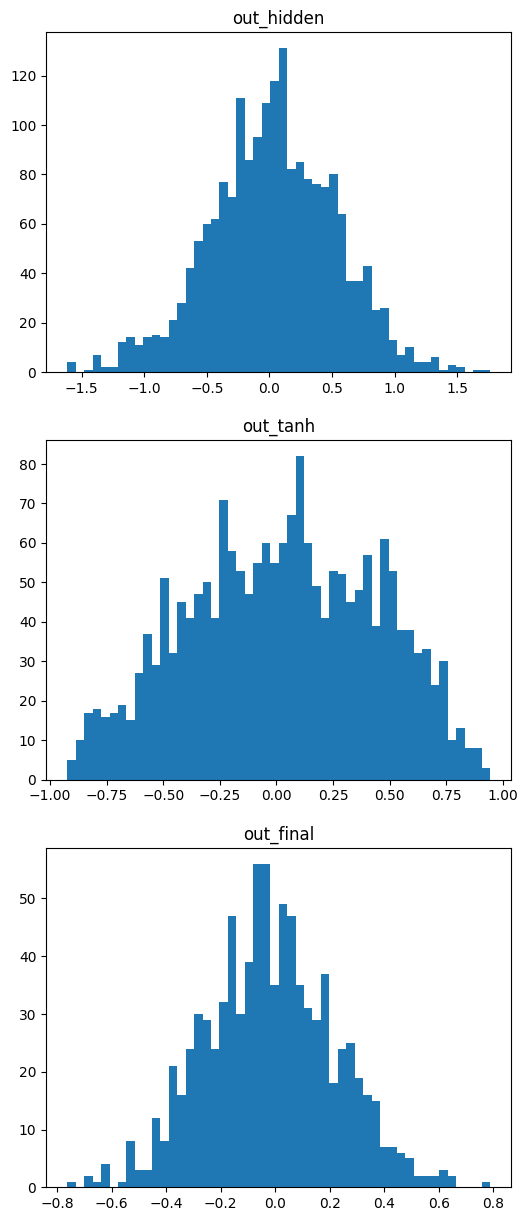

In [72]:
model = MLP(**model_parameters)

uniform_loss = -np.log(1/len(chars))

with torch.no_grad():
    idx = torch.randint(high=Xtr.shape[0], size=(1000,), generator=generator)
    yhat = model(Xtr[idx])
    l = torch.functional.F.cross_entropy(yhat, Ytr[idx])
    
print(f"Expected loss {uniform_loss}, initial loss {l}")

fig, axes = plt.subplots(3, 1, figsize=(6, 15))
with torch.no_grad():
    idx = torch.randint(high=Xtr.shape[0], size=(32,), generator=generator)
    out = model.embedding(Xtr[idx])
    out = model.hidden_layer(out.flatten(1))

    axes[0].hist(out.flatten(0).detach(), bins=50);
    axes[0].set_title("out_hidden")
    
    out = model.hidden_activation(out)

    axes[1].hist(out.flatten(0).detach(), bins=50);
    axes[1].set_title("out_tanh")

    out = model.output_layer(out)

    axes[2].hist(out.flatten(0).detach(), bins=50);
    axes[2].set_title("out_final")

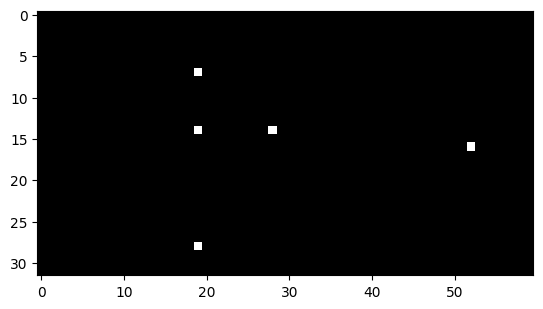

In [73]:
plt.imshow(out_tanh.abs() > 0.95, cmap="gray")

### Learning rate search

In [74]:
lre = torch.linspace(-3, 0, 1000)
lri = 10 ** lre

stats = list()

for lr in lri:
    idx = torch.randperm(Xtr.shape[0], generator=generator)[:batch_size]
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    yhat = model(Xtr[idx, ...])
    l = loss(yhat.float(), Ytr[idx]) #+ regularization(model)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()

    stats.append(l.item())

(-3.0, 0.0)

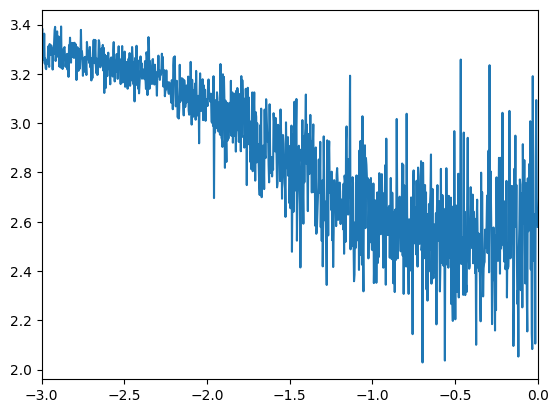

In [75]:
plt.plot(lre, stats)
plt.xlim(-3, 0)
#plt.yscale("log")

### Training

**TO DO**: train diagnostic

In [78]:
model = MLP(**model_parameters)

data_loader = torch.utils.data.DataLoader(
    Dataset(Xtr, Ytr), 
    batch_size=batch_size, 
    shuffle=True, 
    generator=generator
)

optimizer = torch.optim.SGD(model.parameters(), lr=10**(-0.5))
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
    optimizer, lr_lambda=lambda x: 0.9 if x % 3 == 0 and x > 0 else 1.)

loss_history = list()

epochs = 120
for e in range(epochs):
    for x, y in data_loader:
        
        optimizer.zero_grad()
        yhat = model(x)
        l = loss(yhat.float(), y)
        l.backward()
        optimizer.step()

        loss_history.append(l.detach())
        
    with torch.no_grad():
        yhat = model(Xtr)
        ltr = loss(yhat.float(), Ytr)
        yhat_dev = model(Xdev)
        ldev = loss(yhat_dev.float(), Ydev)
        print(f"Epoch {e}: loss {ltr.item():.4f} {ldev.item():.4f}")
    scheduler.step()

Epoch 0: loss 2.3708 2.3956
Epoch 1: loss 2.4000 2.4290
Epoch 2: loss 2.3608 2.3976
Epoch 3: loss 2.3317 2.3676
Epoch 4: loss 2.3547 2.3937
Epoch 5: loss 2.2982 2.3326
Epoch 6: loss 2.3475 2.3860
Epoch 7: loss 2.2687 2.3148
Epoch 8: loss 2.3009 2.3390
Epoch 9: loss 2.2744 2.3185
Epoch 10: loss 2.2880 2.3287
Epoch 11: loss 2.2686 2.3122
Epoch 12: loss 2.2625 2.3113
Epoch 13: loss 2.2335 2.2835
Epoch 14: loss 2.2641 2.3201
Epoch 15: loss 2.2147 2.2635
Epoch 16: loss 2.2042 2.2584
Epoch 17: loss 2.2405 2.2921
Epoch 18: loss 2.2073 2.2534
Epoch 19: loss 2.1901 2.2429
Epoch 20: loss 2.2048 2.2558
Epoch 21: loss 2.2023 2.2509
Epoch 22: loss 2.1977 2.2519
Epoch 23: loss 2.1845 2.2348
Epoch 24: loss 2.1742 2.2231
Epoch 25: loss 2.2232 2.2708
Epoch 26: loss 2.2001 2.2498
Epoch 27: loss 2.1670 2.2224
Epoch 28: loss 2.1598 2.2134
Epoch 29: loss 2.1604 2.2141
Epoch 30: loss 2.1512 2.2043
Epoch 31: loss 2.1384 2.1920
Epoch 32: loss 2.1645 2.2249
Epoch 33: loss 2.1378 2.1920
Epoch 34: loss 2.1341 2.

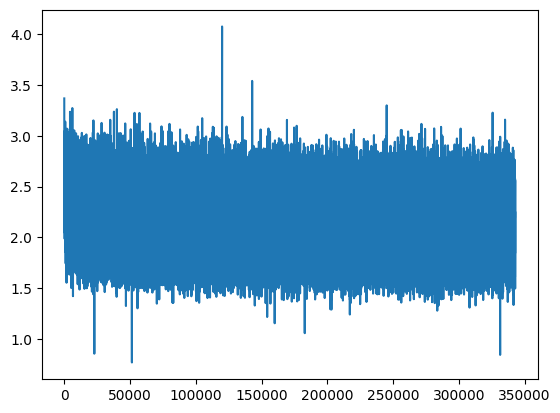

In [55]:
plt.plot(loss_history)

### Evaluation

In [77]:
with torch.no_grad():
    yhat = model(Xtr)
    ltr = loss(yhat.float(), Ytr)
    yhat_dev = model(Xdev)
    ldev = loss(yhat_dev.float(), Ydev)
    yhat_te = model(Xte)
    lte = loss(yhat_te.float(), Yte)
    print(f"Loss: train {ltr.item():.4f} dev {ldev.item():.4f} test {lte:.4f}")

Loss: train 2.0895 dev 2.1467 test 2.1481


## Generate new names

In [57]:
for _ in range(10):
    print(model.generate_name(generator=generator))

damonarelyn.
mersen.
ziiahna.
racope.
harleenomeshulrisa.
hina.
tyreetox.
korahani.
herma.
xson.
